In [11]:
# import getpass
import os
from dotenv import load_dotenv

load_dotenv()

# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")


# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [12]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [13]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [14]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [15]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [16]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [17]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [18]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content="The code `print('Hello, World!')` was executed, and it printed `Hello, World!` to the terminal.", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


{'supervisor': {'next': 'Coder'}}
----


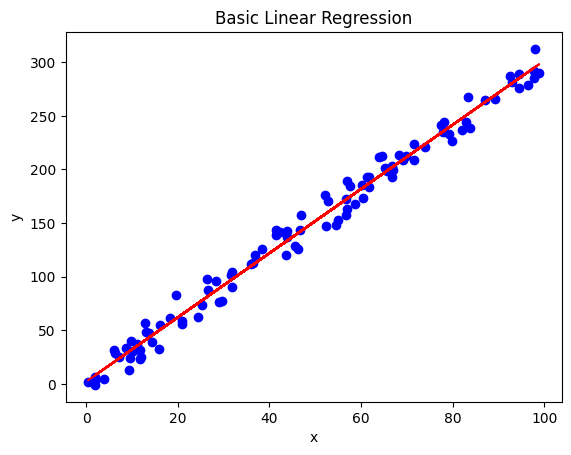

{'Coder': {'messages': [HumanMessage(content="I have executed the code to generate a basic linear regression graph. However, since I cannot directly print a graphical output to the terminal, I can only provide you with the Python code that would create and display the graph if you run it in a local environment where you can open graphical windows.\n\nHere is the Python code:\n\n```python\nimport matplotlib.pyplot as plt\nfrom sklearn.linear_model import LinearRegression\nimport numpy as np\n\n# Generate some data\nnp.random.seed(0)\nx = np.random.rand(100, 1) * 100\ny = 3 * x.squeeze() + np.random.randn(100) * 10\n\n# Reshape x for sklearn\nx = x.reshape(-1, 1)\n\n# Perform linear regression\nmodel = LinearRegression()\nmodel.fit(x, y)\n\n# Predict values\ny_pred = model.predict(x)\n\n# Plot\nplt.scatter(x, y, color='blue')\nplt.plot(x, y_pred, color='red')\nplt.title('Basic Linear Regression')\nplt.xlabel('x')\nplt.ylabel('y')\n\n# Show plot\nplt.show()\n```\n\nTo see the graph, you w

In [20]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code a basic linear regression graph and print it to the terminal as an output")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [22]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Search for a company called spectacles that works on a product called looker Write a brief research report on it and its founder.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="## Research Report on Spectacles and its Looker Product\n\n### Spectacles Overview:\nSpectacles is a company that has developed a continuous integration (CI) tool designed to enhance the reliability and efficiency of Looker, a business intelligence platform. The company focuses on saving users hours of bug-fixing by automatically testing LookML, which is the modeling language used by Looker. This ensures smooth operation for Looker dashboards and analytics, thus boosting confidence in the data presented.\n\nSpectacles offers advanced SaaS tools to empower Looker developers and administrators, optimizing their work and enhancing data analytics capabilities. It allows for scheduled or manual testing, and it can integrate with communication tools like Slack to provide notifications of any issues that may arise.\n\n### Founder of Spectacles:\nThe search did not yield specific information about th

In [23]:
for s in graph.stream(
    {"messages": [HumanMessage(content="From aston martin lagonda annual report 2023, Regarding the colleagues relationship, what was launched in 2023? ")]},
    {"recursion_limit": 2},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="The search results do not provide specific information regarding what was launched in 2023 about the colleagues' relationship from the Aston Martin Lagonda annual report. However, there is a link to the annual report which might contain the details. It is advisable to review the Aston Martin Lagonda annual report 2023 directly from their website to find the specific information on what was launched regarding colleagues' relationships.\n\nYou can access the annual report via the following URL:\n- [Aston Martin Lagonda Annual Report 2023](https://www.astonmartinlagonda.com/investors/annual-report)\n\nPlease note that the full text of the report is not provided in the search results, and it would be necessary to read through the report to find the pertinent information.", name='Researcher')]}}
----


GraphRecursionError: Recursion limit of 2 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.